# Robust Successive Projection Algorithm demo

This notebook requires downloading the `f100517t01p00r14rdn_b` AVIRIS scene and unzipping into the `data` subdirectory.

In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysptools.abundance_maps import FCLS
import rasterio as rio
from tqdm.autonotebook import tqdm, trange

from hyperspectral.spectra import Spectrum
from hyperspectral.unmixing import rspa

/home/jpolchlopek/.python_envs/nasa/lib/python3.6/site-packages/ipykernel/__main__.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Endmember Determination

Start by taking a manageable extract from the source image.

In [2]:
extract_loc = "data/rspa_extract.npz"
if not os.path.exists(extract_loc):
    target_file = 'data/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img'
    with rio.open(target_file) as ds:
        raw = ds.read().astype(np.uint16)
        img = np.dstack(raw[:,list(range(0,ds.shape[0],13)),:].astype(np.float))
        del raw
        img[img > 60000] = 0
    np.savez(extract_loc, img=img)
else:
    img = np.load(extract_loc)['img']
img.shape

(2013, 796, 224)

In [6]:
aviris_wavelengths = list(pd.read_csv('data/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b.spc', sep="\t", header=None, names=['center','fwhm','center_uncertainty','fwhm_uncertainty','channel'])['center'])

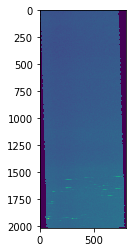

In [3]:
plt.imshow(img[:,:,0])

### RSPA

In [4]:
ems_rspa = rspa(img, 6, 40, β=4.0)

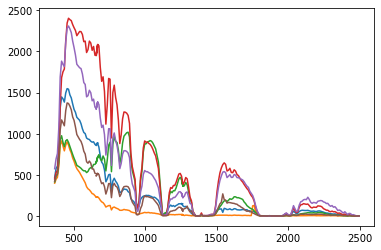

In [4]:
for i in range(len(ems_rspa)):
    plt.plot(aviris_wavelengths, ems_rspa[i])

In [6]:
np.savez('data/rspa_dwh_ems_6.npz', ems=ems_rspa)

### NFINDR

In [5]:
from pysptools.eea import NFINDR

nfindr = NFINDR()
ems_nfindr = nfindr.extract(img, 4, ATGP_init=True)

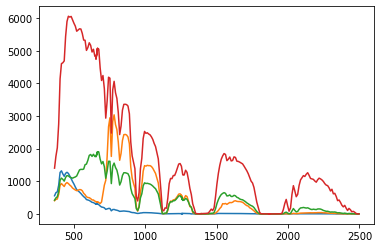

In [7]:
for i in range(len(ems_nfindr)):
    plt.plot(aviris_wavelengths, ems_nfindr[i])

In [7]:
np.savez('data/nfindr_dwh_ems_4.npz', ems=ems_nfindr)

### Compare to a reference spectrum

Spectrum used here can be found at https://crustal.usgs.gov/speclab/QueryAll07a.php

In [14]:
from scipy.signal import resample
spectrum = []
with open('data/splib07a_Oil_Water_Benzene17_DWH10-3_ASDHRa_AREF.txt', 'r') as f:
    f.readline()
    for line in f.readlines():
        spectrum.append(float(line))
spectrum = np.array(spectrum)
spectrum = spectrum / np.linalg.norm(spectrum, ord=2)
#spectrum_normalized = resample(spectrum, 224) #- spectrum.mean()

In [29]:
reference = pd.concat([
    pd.read_csv('data/splib07a_Wavelengths_ASD_0.35-2.5_microns_2151_ch.txt'),
    pd.read_csv('data/splib07a_Oil_Water_Benzene17_DWH10-3_ASDHRa_AREF.txt')
], axis=1)
reference.columns = ['wavelength', '60:40+Benzene17']
reference

wavelength  radiance
0          0.350  0.007018
1          0.351  0.007018
2          0.352  0.006482
3          0.353  0.005557
4          0.354  0.005286
...          ...       ...
2146       2.496  0.045795
2147       2.497  0.045221
2148       2.498  0.044601
2149       2.499  0.045359
2150       2.500  0.045359

[2151 rows x 2 columns]

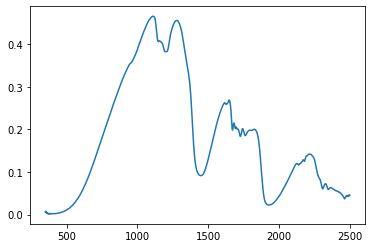

In [33]:
plt.plot(reference['wavelength']*1000, reference['60:40+Benzene17'])

## Abundance Maps

Uses `pysptools` to develop fully-constrained least squares solutions for per-pixel abundances.

Results are presented as six images (one per derived endmember) per chunk of the scene (top, middle, bottom).  Top contains a landmass and water with no obvious oil spill (though there may be oil accumulated on the land, it's unclear).  Middle contains oil and visible oil slick.  Bottom contains water and cloud with no obvious oil.

In sum, the first two endmembers appear to identify features of water, the third captures oil (but also, confusingly, land), the final three seem most activated by cloud features.

In [8]:
target_file = 'data/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img'

with rio.open(target_file) as ds:
    #w = rio.windows.Window(50,50,512,4096) # Top
    w = rio.windows.Window(50,5000,512,4096) # Middle (oil!)
    #w = rio.windows.Window(120,20000,512,4096) # Bottom

    img = np.dstack(ds.read(window=w).astype(np.uint16).astype(np.float))
    img[img > 60000] = 0

img.shape

(4096, 512, 224)

### RSPA

In [9]:
ems_rspa = np.load('data/rspa_dwh_ems_6.npz')['ems']

In [10]:
fcls = FCLS()
res_rspa = fcls.map(img, ems_rspa)

#### Top of scene

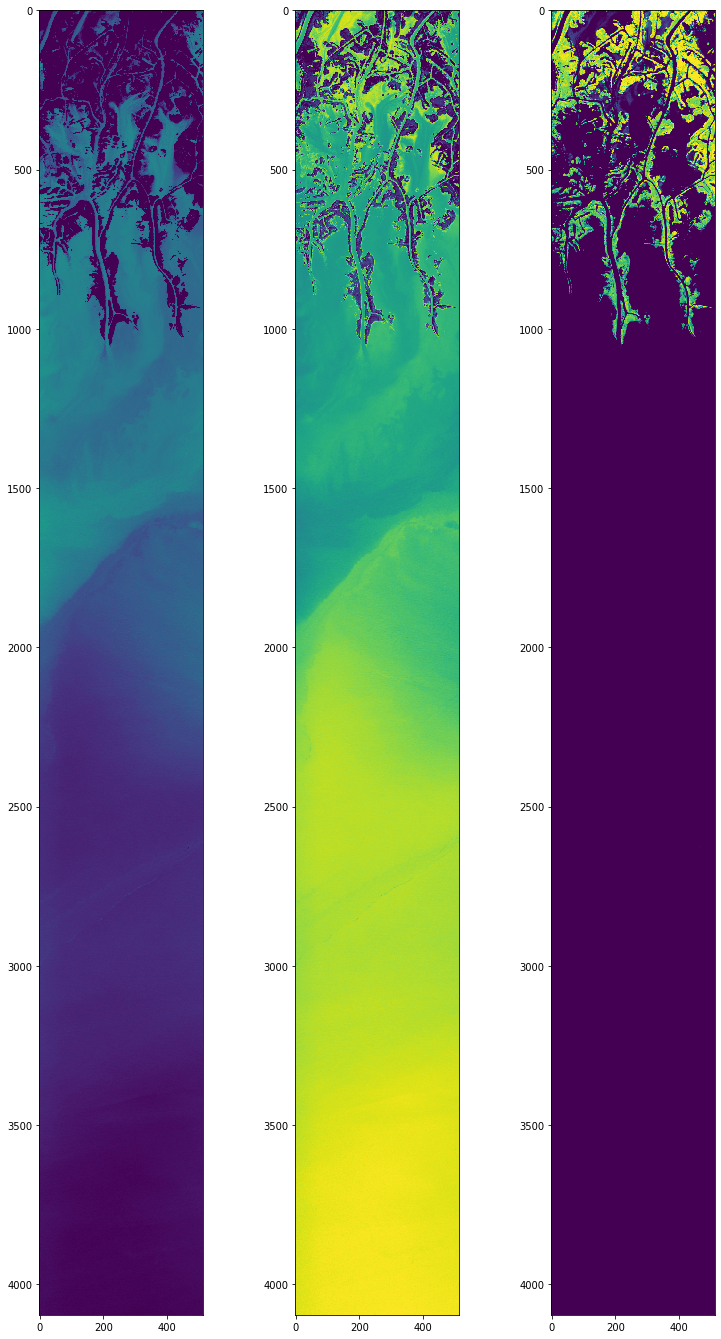

In [25]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3):
    ax[i].imshow(res_rspa[:,:,i],vmax=1)

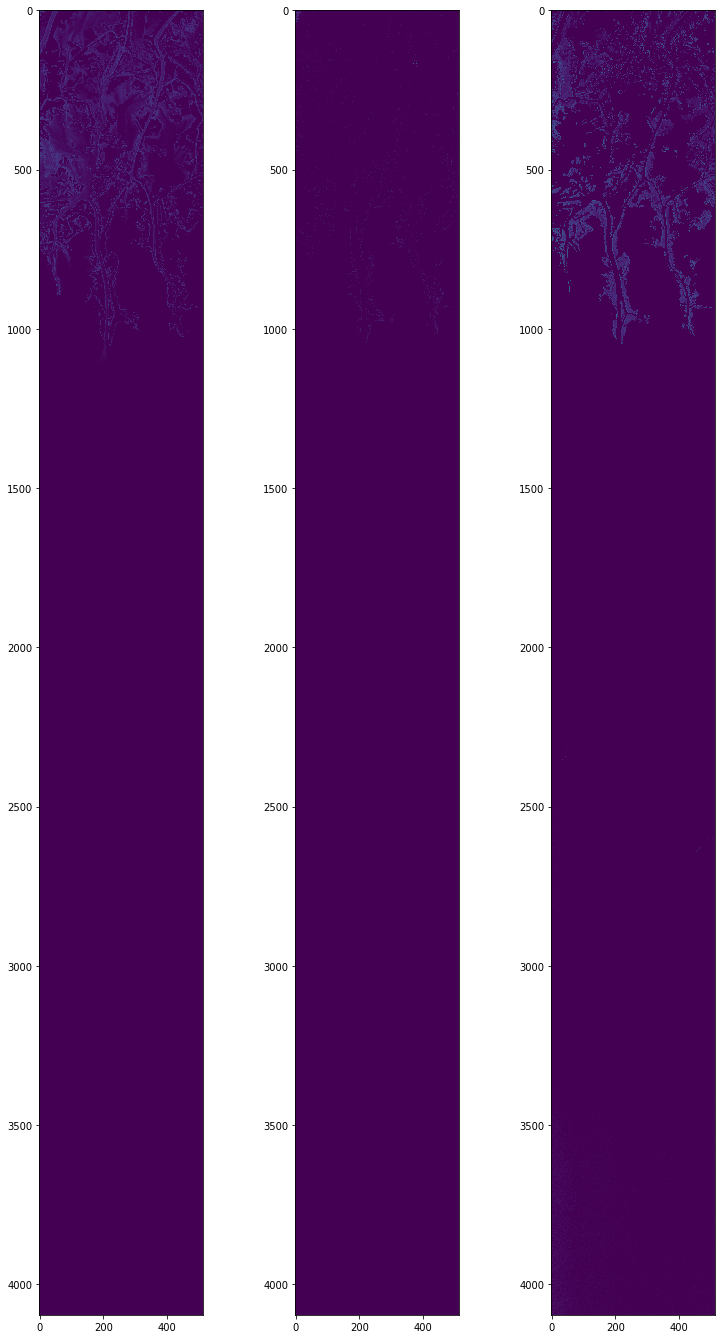

In [26]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3,6):
    ax[i-3].imshow(res_rspa[:,:,i],vmax=1)

#### Middle of scene (here there be oil)

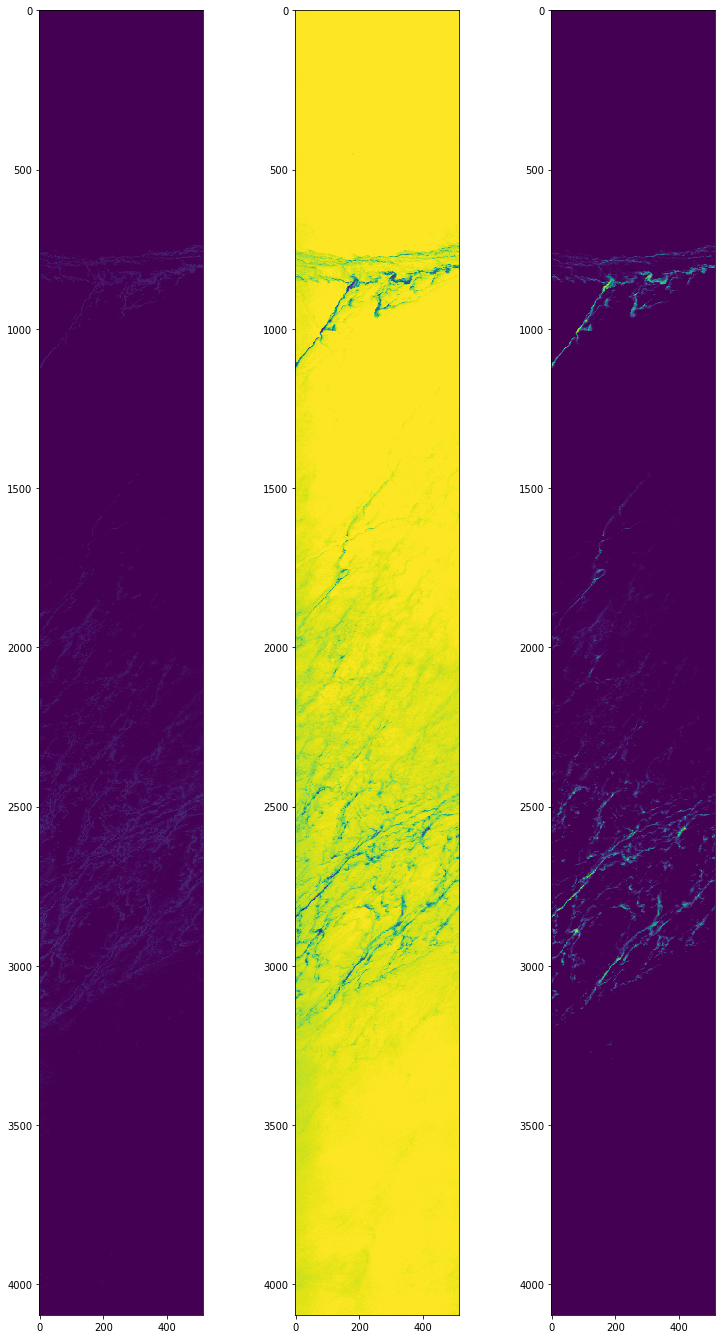

In [11]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3):
    ax[i].imshow(res_rspa[:,:,i],vmax=1)

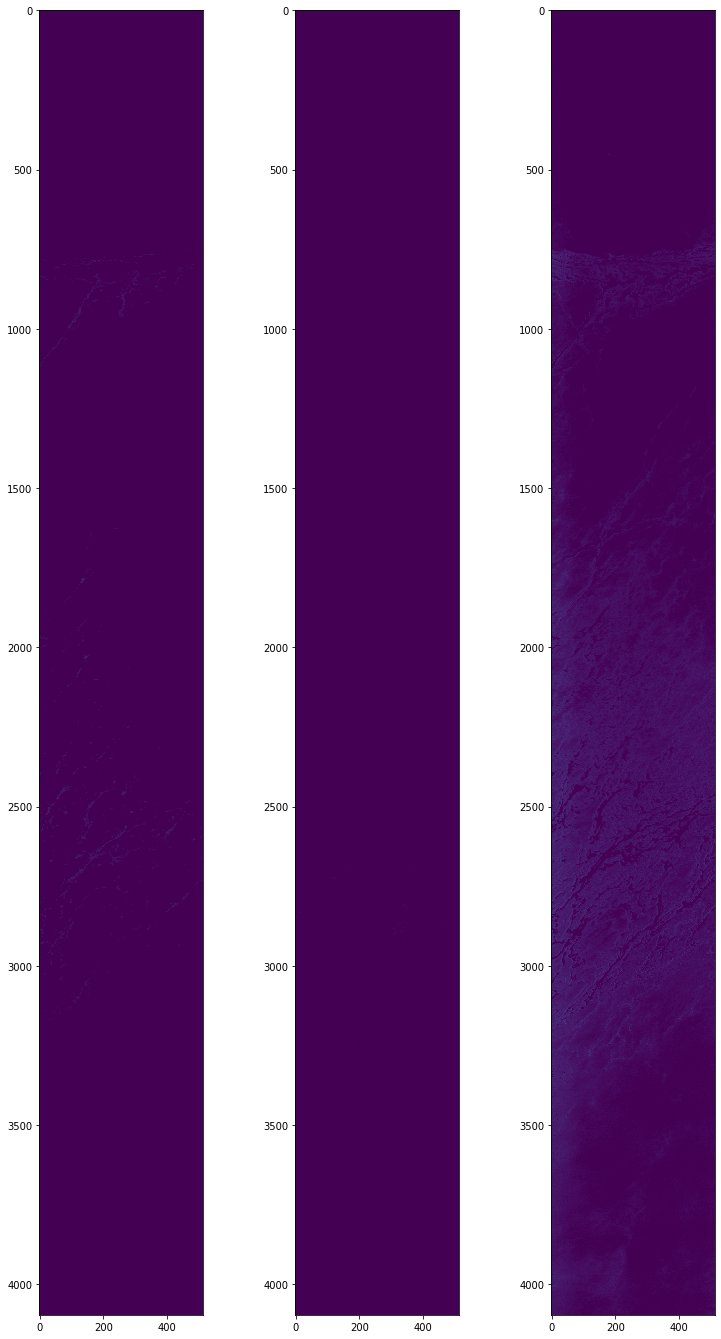

In [12]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3,6):
    ax[i-3].imshow(res_rspa[:,:,i],vmax=1)

#### Bottom of scene

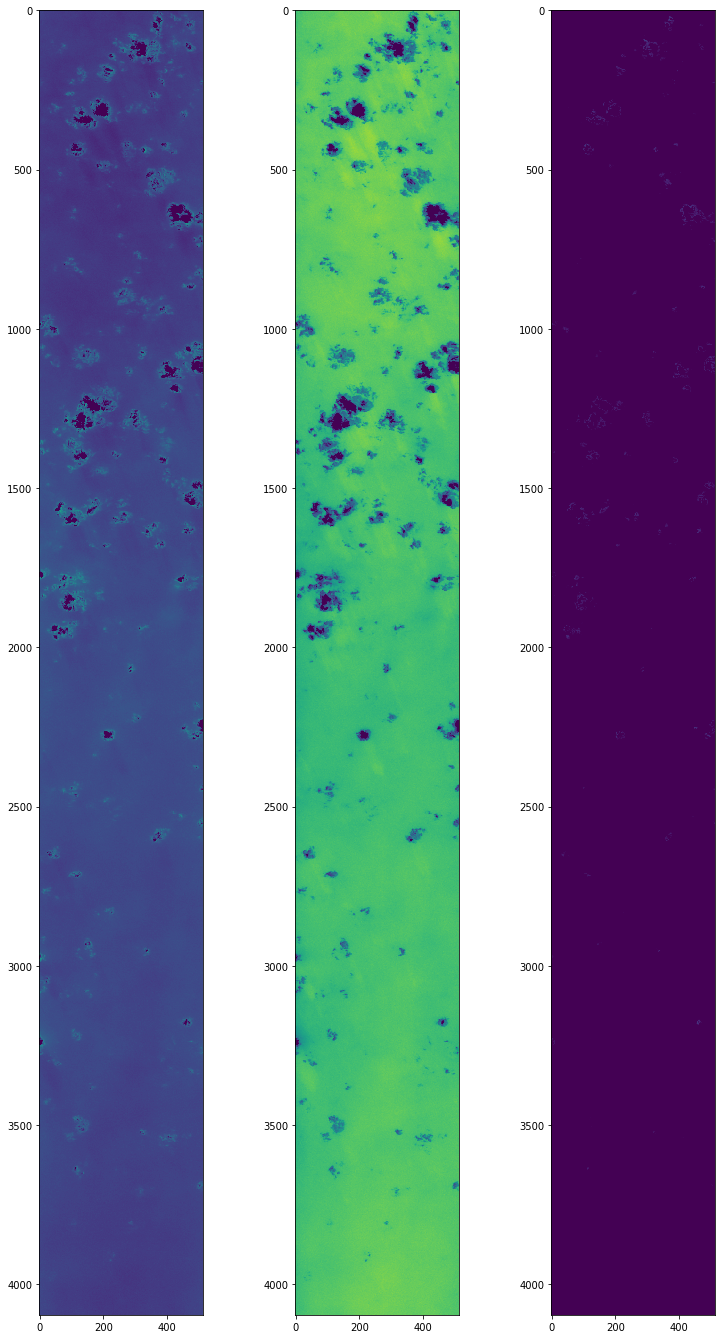

In [30]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3):
    ax[i].imshow(res_rspa[:,:,i],vmax=1)

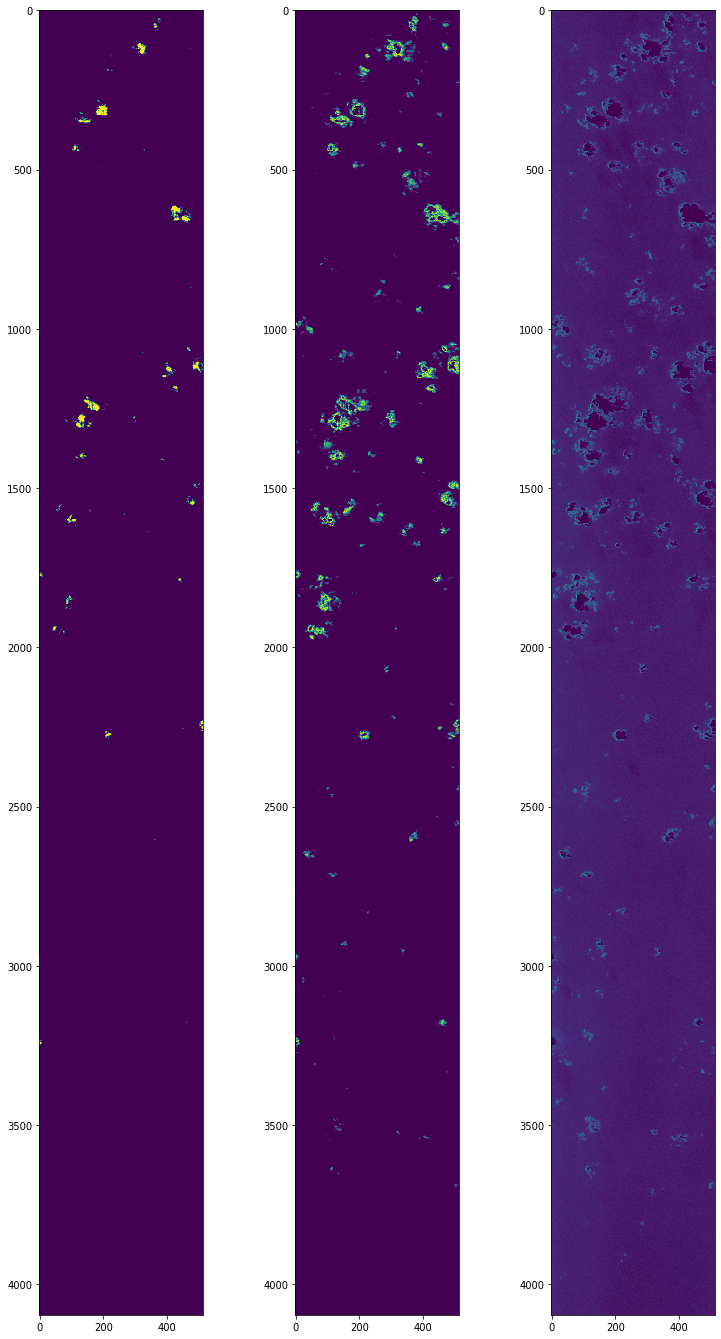

In [31]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3,6):
    ax[i-3].imshow(res_rspa[:,:,i],vmax=1)

### NFINDR

In [5]:
ems_nfindr = np.load('data/nfindr_dwh_ems_4.npz')['ems']

In [6]:
fcls = FCLS()
res_nfindr = fcls.map(img, ems_nfindr)

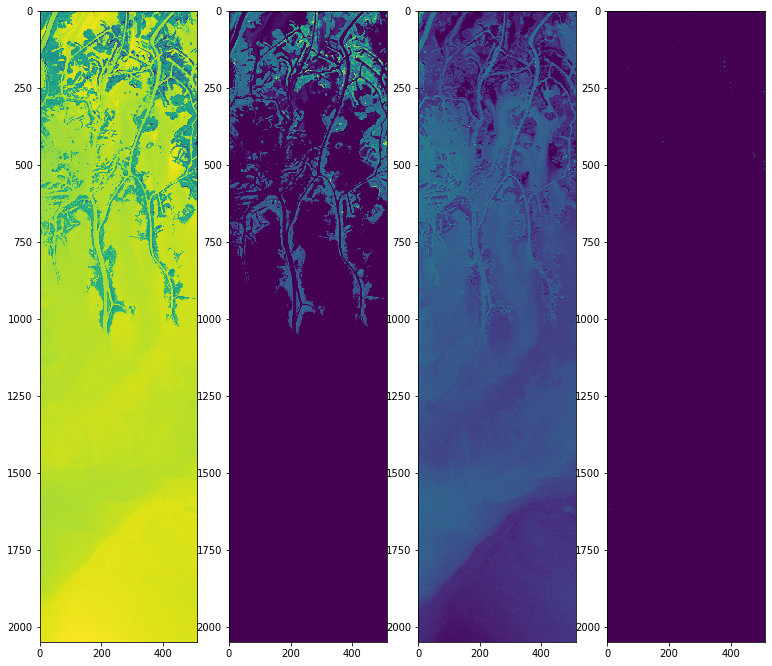

In [7]:
_, ax = plt.subplots(1, 4, figsize=(13,13))
for i in range(4):
    ax[i].imshow(res_nfindr[:,:,i])

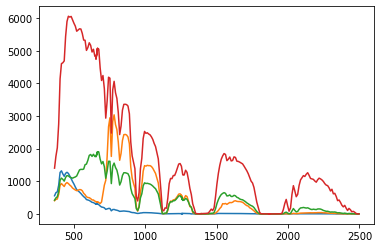

In [36]:
for i in range(len(ems_nfindr)):
    plt.plot(aviris_wavelengths, ems_nfindr[i])

## An FCLS Mini-experiment

Using FCLS as the method for developing the abundance maps can produce some odd results.  This section makes some observations.

#### Focus on soiled area

For this example, let's see what happens when we try to use too many endmembers.  The source image for RSPA is a clear section of ocean with some oil spill activity.

In [2]:
extract_loc = "data/rspa_oiled_extract.npz"
if not os.path.exists(extract_loc):
    target_file = 'data/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img'
    with rio.open(target_file) as ds:
        raw = ds.read().astype(np.uint16)
        img = np.transpose(raw[:,5000:7500,:].astype(np.float), (1,2,0))
        del raw
        img[img > 60000] = 0
    np.savez(extract_loc, img=img)
else:
    img = np.load(extract_loc)['img']
img.shape

(2500, 796, 224)

In [3]:
ems_oil_rspa = rspa(img, 6, 40)

In [4]:
np.savez('data/rspa_dwh_ems_oiled_6.npz', ems=ems_oil_rspa)

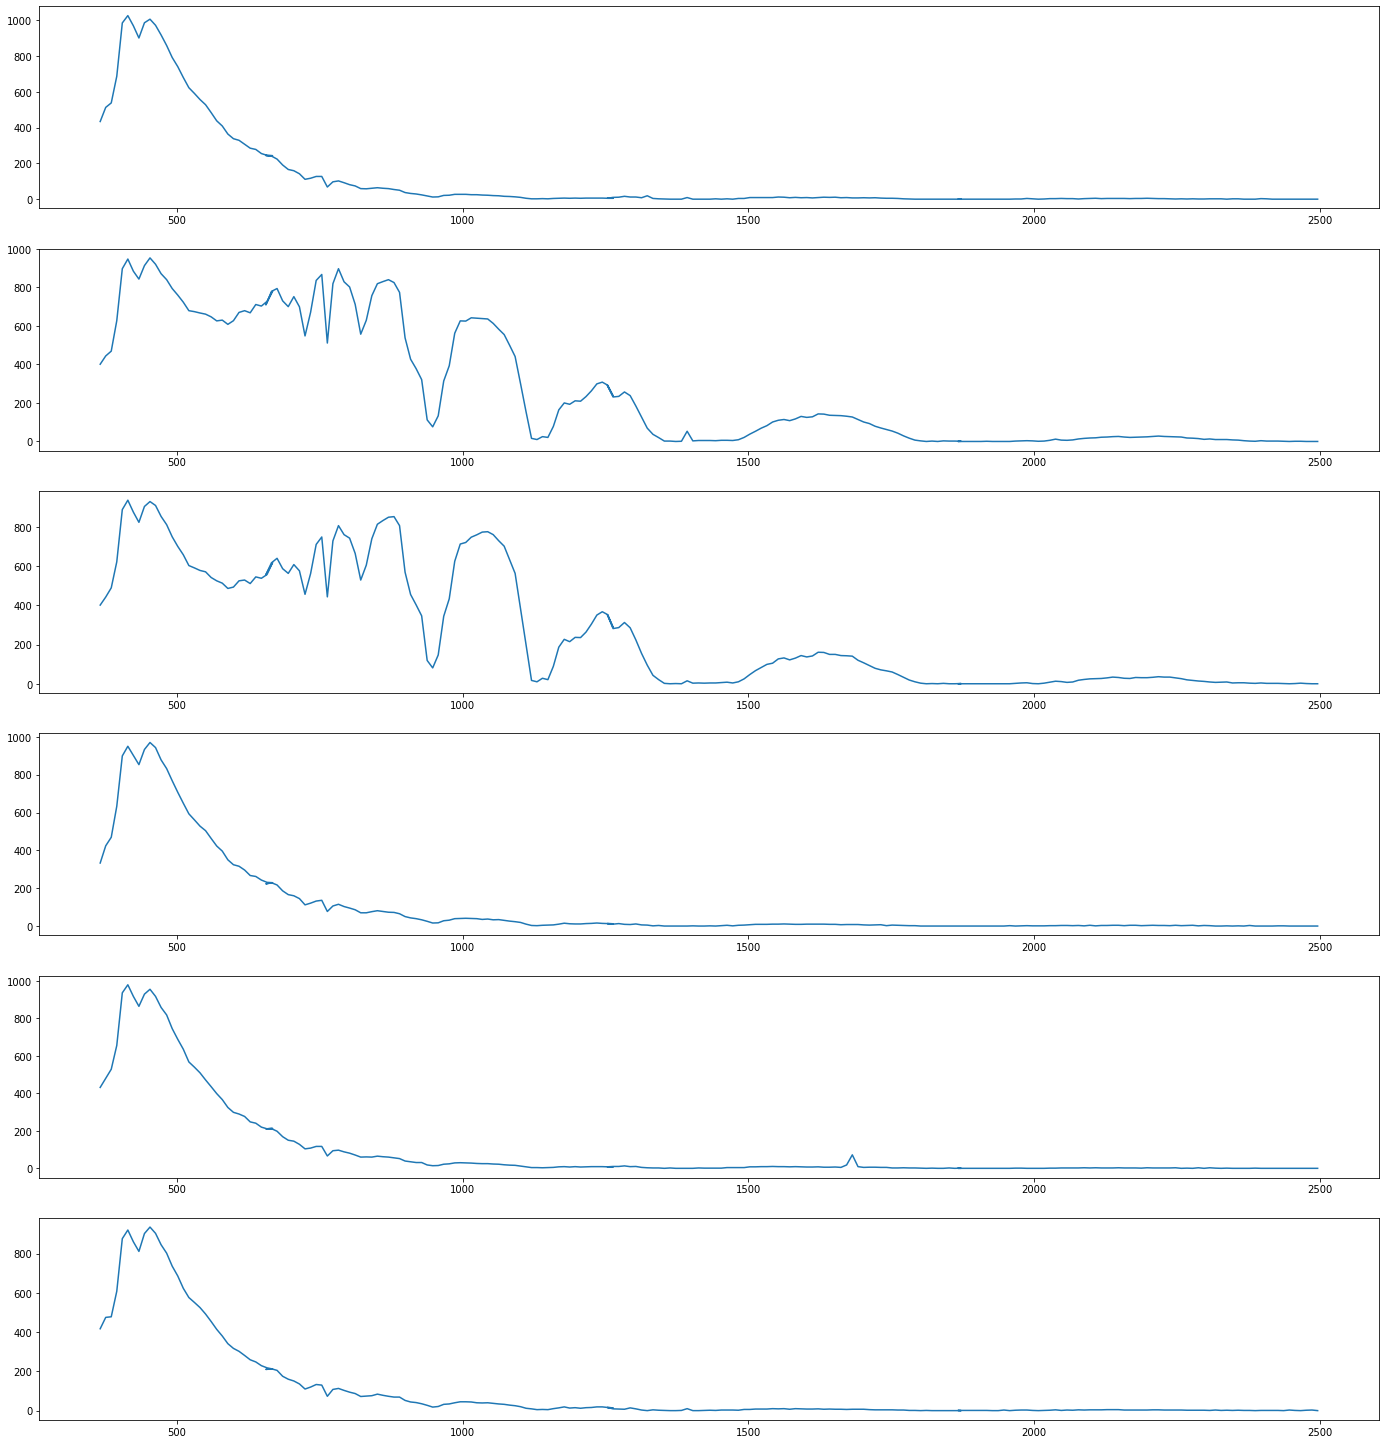

In [10]:
_, ax = plt.subplots(len(ems_oil_rspa),1, figsize=(24,26))
for i in range(len(ems_oil_rspa)):
    ax[i].plot(aviris_wavelengths, ems_oil_rspa[i])

It's fairly clear that there are only two substances, and the signals found are spurious contributors (i.e., these were picked on the basis of common noise features, not for any substantive reasons).

Let's pass these through the fully-constrained least squares fit.

In [11]:
fcls = FCLS()
res_oil_rspa = fcls.map(img, ems_oil_rspa)

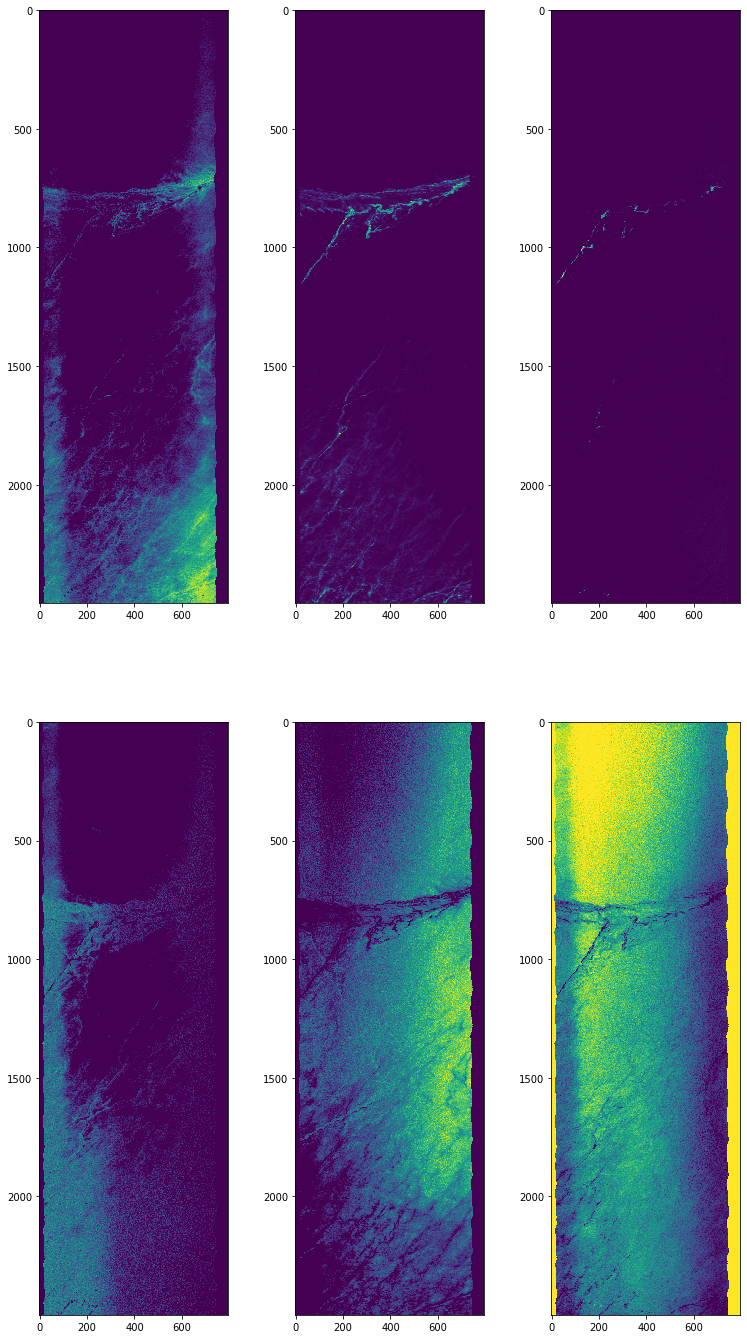

In [13]:
_, ax = plt.subplots(2, 3, figsize=(13,24))
for i in range(6):
    ax[i//3,i%3].imshow(res_oil_rspa[:,:,i],vmax=1)

These components clearly decompose the same signals into subordinate parts, muddying the interpretation.  It's better to look at the signals that carry the lion's share of information:

In [14]:
fcls = FCLS()
res_oil_rspa_2 = fcls.map(img, ems_oil_rspa[0:2])

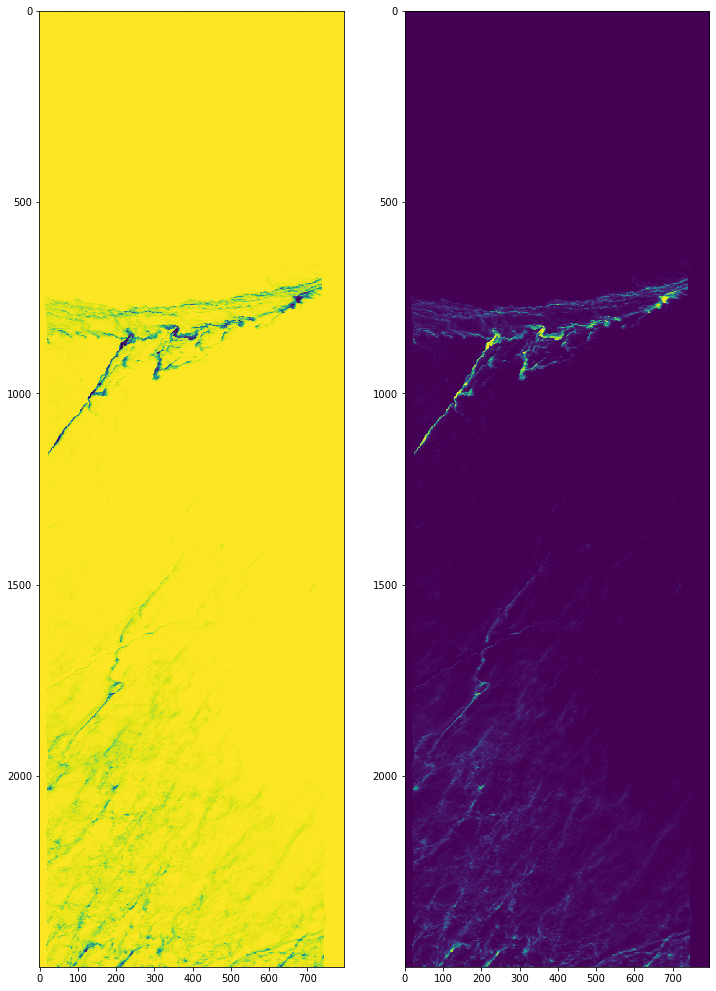

In [18]:
_, ax = plt.subplots(1, 2, figsize=(12,30))
for i in range(2):
    ax[i].imshow(res_oil_rspa_2[:,:,i],vmax=1)

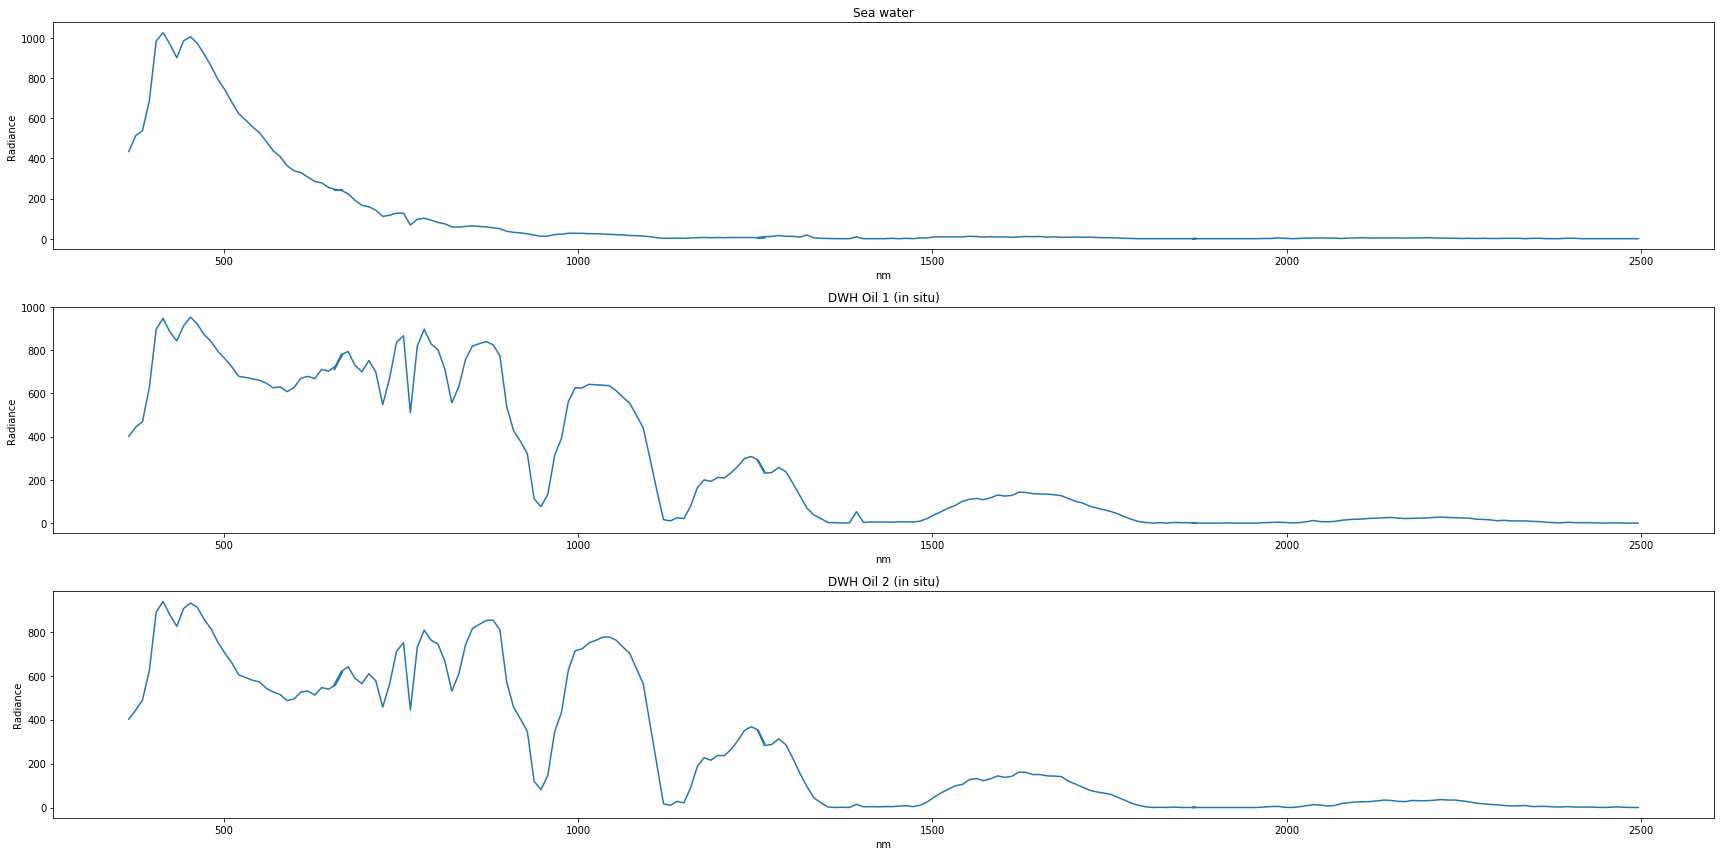

In [16]:
fig, ax = plt.subplots(3,1, figsize=(24,12))
λs = min(aviris_wavelengths), max(aviris_wavelengths)
spectra = [
    Spectrum('Sea water', 'natural', 'water', λs[0], λs[1], 224, {'X Units': 'nm', 'Y Units': 'Radiance'}, aviris_wavelengths, ems_oil_rspa[0]),
    Spectrum('DWH Oil 1 (in situ)', 'manmade', 'hydrocarbon', λs[0], λs[1], 224, {'X Units': 'nm', 'Y Units': 'Radiance'}, aviris_wavelengths, ems_oil_rspa[1]),
    Spectrum('DWH Oil 2 (in situ)', 'manmade', 'hydrocarbon', λs[0], λs[1], 224, {'X Units': 'nm', 'Y Units': 'Radiance'}, aviris_wavelengths, ems_oil_rspa[2])
]
for i in range(3):
    spectra[i].plot(ax=ax[i])
fig.tight_layout()

It's worth noting that the discovered oil spectra carry an echo of the seawater signal, which can be seen in the sub-500nm portion of the spectra.  RSPA cannot fundamentally untangle a mixed signal when there are no pure pixels to be found in the source image.